In [1]:
import numpy as np
import cv2
import csv
import glob
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from library_functions import *

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn import svm
from sklearn.utils import shuffle
from moviepy.editor import VideoFileClip
    
%matplotlib inline


#generate samples from the udacity images - must be run only once as it creates and saves the 64x64 images
filename=[]
image=[]
frames=[]
car_images=[]
num_car_images=0
num_non_car_images=0
with open('train_images/object-detection-crowdai/labels.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:     
        if line[0] == 'xmin':
           continue
        if filename != line[4]:
            if len(filename):
                #six random samples from each image
                for i in range(6):
                    while 1:
                        img_coord = (np.random.randint(image.shape[1]-64), 250+np.random.randint(image.shape[0]-314))
                        if frames[img_coord[1], img_coord[0]] == 0:
                            non_car_img = image[img_coord[1]:img_coord[1]+64, img_coord[0]:img_coord[0]+64, :]
                            num_non_car_images = num_non_car_images + 1                            
                            cv2.imwrite("train_images/my/non_car{:05d}.png".format(num_non_car_images), non_car_img)
                            break
            filename = line[4]
            image = mpimg.imread('train_images/object-detection-crowdai/'+filename)            
            frames=np.zeros_like(image[:,:,0])
        frames[int(line[1])-32:int(line[3]), int(line[0])-32:int(line[2])] = 1        
        if line[5] == 'Car':            
            xsize = int(line[2]) - int(line[0])
            ysize = int(line[3]) - int(line[1])       
            if xsize>32 and ysize>32:
                car_img = cv2.resize(image[int(line[1]):int(line[3]), int(line[0]):int(line[2]), :], (64,64))
                car_images.append(car_img) 
                num_car_images = num_car_images+1
                cv2.imwrite("train_images/my/car{:05d}.png".format(num_car_images), car_img)
        
                                   
print("Number of car images: {}".format(num_car_images))           
print("Number of car images: {}".format(num_non_car_images))            

In [2]:
#load samples
files = glob.glob('train_images/my/*.png')
cars = []
notcars = []
for fname in files:
    #img = mpimg.imread(fname)
    if 'non_car' in fname:
        if len(notcars)<0:
          notcars.append(fname)
    else:
        if len(cars)<0:
          cars.append(fname)       
print("Number of car images: {}".format(len(cars)))            
print("Number of non-car images: {}".format(len(notcars))) 

Number of car images: 0
Number of non-car images: 0


In [3]:
#load samples
notcar_images = ('Extras', 'GTI')
car_images = ('GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted')
for dir in notcar_images:
    for fname in glob.glob('train_images/non-vehicles/'+dir+'/*.png'):
        notcars.append(fname)
for dir in car_images:
    for fname in glob.glob('train_images/vehicles/'+dir+'/*.png'):
        cars.append(fname)           
            
print("Number of car images: {}".format(len(cars)))            
print("Number of non-car images: {}".format(len(notcars))) 

Number of car images: 8792
Number of non-car images: 8968


In [4]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#YCrCb/13/16 = 94.89, 0.0225
#YCrCb/13/8 = 94.17, 0.021
#HLS/13/16 = 94.93, 0.017
#YUV/13/16 = 94.18, 0.02
orient = 13  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 8   # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

In [5]:
print("Creating features...")
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print("Features created")
print(" time elapsed: ", round(t2-t, 2))

split_idx_cars = int(len(cars)*0.8)
split_idx_notcars = int(len(notcars)*0.8)

X_train = np.vstack((car_features[:split_idx_cars], notcar_features[:split_idx_notcars])).astype(np.float64)
y_train = np.hstack((np.ones(split_idx_cars), np.zeros(split_idx_notcars)))

X_test = np.vstack((car_features[split_idx_cars:], notcar_features[split_idx_notcars:])).astype(np.float64)
y_test = np.hstack((np.ones(len(cars)-split_idx_cars), np.zeros(len(notcars)-split_idx_notcars)))

"""
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
"""
print('Feature vector length:', len(X_train[0]))

Creating features...
Features created
 time elapsed:  77.42
Feature vector length: 7644


In [6]:
t=time.time()
# Use a linear SVC 
svc = svm.LinearSVC()
svc.fit(X_train, y_train)
# Check the training time for the SVC
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

#Saving classifier
with open('svc.pkl', 'wb') as fid:
    pickle.dump(svc, fid) 

6.02 Seconds to train SVC...
Test Accuracy of SVC =  0.9485
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.]
For these 100 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.02 Seconds to predict 100 labels with SVC


In [7]:
with open('svc.pkl', 'rb') as fid:
    svc = pickle.load(fid)
#with open('scaler.pkl', 'rb') as fid:
#    X_scaler = pickle.load(fid)     

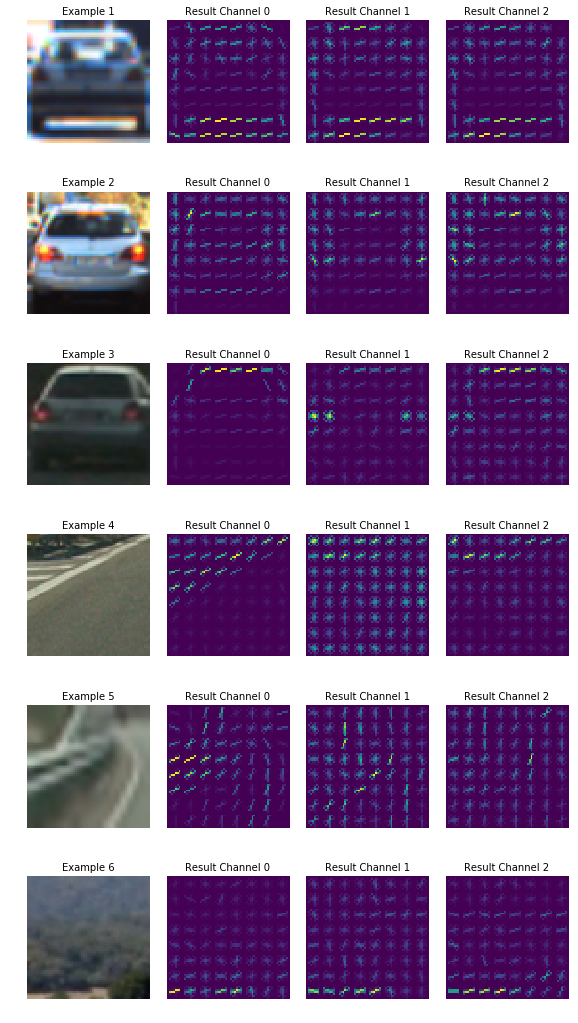

In [8]:
#Hog example images
images = []
num_images = 0
cars = shuffle(cars)
notcars = shuffle(notcars)
for img in cars[:3]:
    images.append(mpimg.imread(img))
for img in notcars[:3]:
    images.append(mpimg.imread(img))    

fig, axs = plt.subplots(6, 4, figsize=(10,18))
fig.subplots_adjust(hspace = .4, wspace=.002)
axs = axs.ravel()
i = 0
for img in images:
    converted = convert_rgb(img, color_space)
    (features, hog1) = get_hog_features(converted[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    (features, hog2) = get_hog_features(converted[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    (features, hog3) = get_hog_features(converted[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    axs[i].imshow(img)
    axs[i].set_title("Example {0}".format(int(i//4)+1), fontsize=10)
    axs[i].axis('off')
    axs[i+1].imshow(hog1)
    axs[i+1].set_title("Result Channel 0", fontsize=10)
    axs[i+1].axis('off')
    axs[i+2].imshow(hog2)
    axs[i+2].set_title("Result Channel 1", fontsize=10)
    axs[i+2].axis('off')
    axs[i+3].imshow(hog3)
    axs[i+3].set_title("Result Channel 2", fontsize=10)
    axs[i+3].axis('off')
    i = i+4
    

In [12]:
class Detector:
    def __init__(self, hist_len=15):       
        self.hist_len = hist_len
        self.boxes_hist = []
                
    def add_boxes(self, boxes):
        self.boxes_hist.append(boxes)
        if len(self.boxes_hist)>self.hist_len:
            self.boxes_hist.pop(0)
            
    def get_heatmap(self, img):
        heat =  np.zeros_like(img[:,:,0]).astype(np.float)
        for rectangles in self.boxes_hist:
           heat = add_heat(heat,rectangles) 
        return heat
    
    def find_boxes(self, img):
        rectangles = []     
        cnt = 0
        #cnt = find_cars(img, color_space, hog_channel, rectangles, 380, 600, 1, svc, orient, pix_per_cell, cell_per_block)
        #cnt += find_cars(img, color_space, hog_channel, rectangles, 408, 472, 1, svc, orient, pix_per_cell, cell_per_block)
        #cnt += find_cars(img, color_space, hog_channel, rectangles, 416, 480, 1, svc, orient, pix_per_cell, cell_per_block)
        #cnt += find_cars(img, color_space, hog_channel, rectangles, 424, 488, 1, svc, orient, pix_per_cell, cell_per_block)
        #cnt += find_cars(img, color_space, hog_channel, rectangles, 432, 496, 1, svc, orient, pix_per_cell, cell_per_block)
        cnt += find_cars(img, color_space, hog_channel, rectangles, 380, 600, 1.5, svc, orient, pix_per_cell, cell_per_block)
        cnt += find_cars(img, color_space, hog_channel, rectangles, 400, 600, 2, svc, orient, pix_per_cell, cell_per_block)
        #cnt += find_cars(img, color_space, hog_channel, rectangles, 400, 600, 2, svc, orient, pix_per_cell, cell_per_block)
        return rectangles
    
    def get_local_heatmap(self, img):
        #Find cars on the image
        rectangles = self.find_boxes(img)
        #return draw_boxes(img, rectangles) 
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        
        # Add heat to each box in box list
        heat = add_heat(heat,rectangles)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)
        return heat
    
    def process_image(self, img, unfiltered = False):
        rectangles = self.find_boxes(img)
        if unfiltered: 
            return draw_boxes(img, rectangles) 
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)        
        # Add heat to each box in box list
        heat = add_heat(heat,rectangles)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)
        # Find final boxes from heatmap using label function
        labels = label(heat)
        return draw_labeled_bboxes(np.copy(img), labels)
        
    def process_video(self, img):
        rectangles = self.find_boxes(img)
        #return draw_boxes(img, rectangles) 
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        
        # Add heat to each box in box list
        heat = add_heat(heat,rectangles)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)
        # Find final boxes from heatmap using label function
        labels = label(heat)
        #return draw_labeled_bboxes(np.copy(img), labels)
        local_boxes = get_labeled_bboxes(heat, labels)
        self.add_boxes(local_boxes)
        #self.add_boxes(rectangles)

        heat = self.get_heatmap(img)
        heat = apply_threshold(heat,4)
        
        labels = label(heat)
        return draw_labeled_bboxes(np.copy(img), labels)

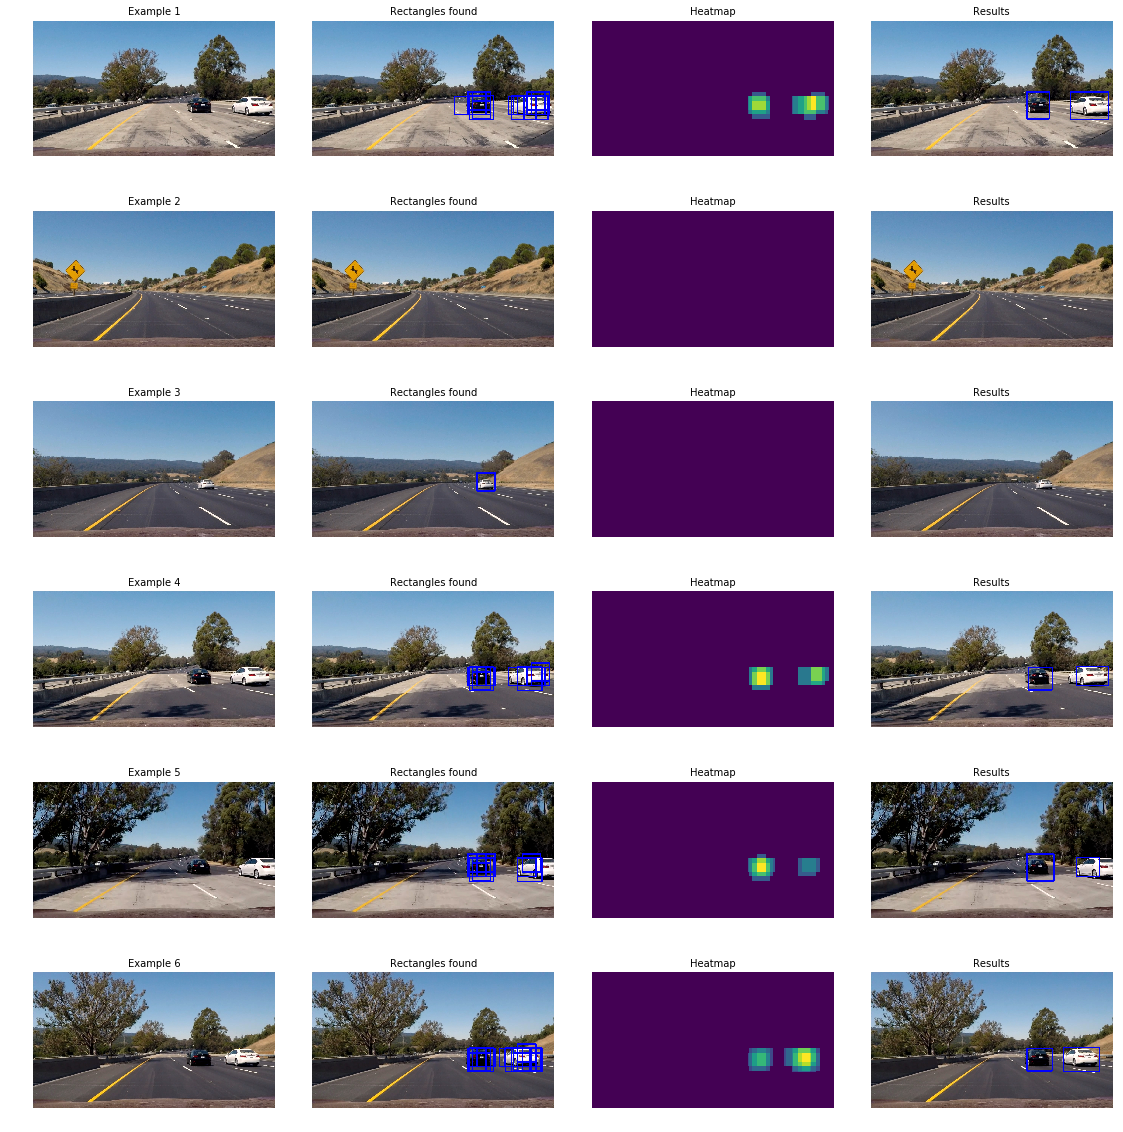

In [13]:
detector = Detector()
fig, axs = plt.subplots(6, 4, figsize=(20,20))
fig.subplots_adjust(hspace = .4, wspace=.002)
axs = axs.ravel()

test_images = glob.glob('test_images/*.jpg')
i = 0
for image in test_images:
    test_image = mpimg.imread(image)
    axs[i].imshow(test_image)
    axs[i].set_title("Example {0}".format(int(i//4)+1), fontsize=10)
    axs[i].axis('off')
    axs[i+1].imshow(detector.process_image(test_image, True))
    axs[i+1].set_title("Rectangles found", fontsize=10)
    axs[i+1].axis('off')
    axs[i+2].imshow(np.clip(detector.get_local_heatmap(test_image), 0, 255))
    axs[i+2].set_title("Heatmap", fontsize=10)
    axs[i+2].axis('off')
    axs[i+3].imshow(detector.process_image(test_image, False))
    axs[i+3].set_title("Results", fontsize=10)
    axs[i+3].axis('off')
    i = i+4

detector = Detector()
test_images = glob.glob('./b/bscap*.jpg')

fig, axs = plt.subplots(22, 2, figsize=(16,100))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

i = 0
for im in test_images:
    img = mpimg.imread(im)
    axs[i].imshow(img)
    #axs[i].axis('off')
    axs[i+1].imshow(detector.process_image(img, True))
    #axs[i+1].axis('off')
    i+=2

In [14]:
#Processing the video file
input = "test_video.mp4"
output = "output_test.mp4"
input = "project_video.mp4"
output = "output.mp4"

detector = Detector()
test_clip = VideoFileClip(input)
    
new_clip = test_clip.fl_image( detector.process_video )
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:52<00:00,  2.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 6min 53s
